<a href="https://colab.research.google.com/github/kirwarobert/cnn/blob/main/hand_written_digit_recognition_using_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade imgaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 35.7 MB/s eta 0:00:00


In [ ]:
# LOAD LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
# GLOBAL VARIABLES
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [ ]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(tf.__version__)

2.18.0


# **2. Data Preprocessing**

# 2.1 Load Data

Our first step is to load the data and divide it into a training and testing dataset. The MNIST dataset can be downloaded directly from TensorFlow and has already been divided. Run the next cell to import the data.

x_train is the dataset of 28x28 images of handwritten digits that the model will be trained on.

y_train is the dataset of labels that correspond to x_train.

x_test is the dataset of 28x28 images of handwritten digits that the model will be tested on.

y_test is the dataset of labels that correspond to x_test. **

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


[40633 21024 29323   146 37093 31276 41804 48740]


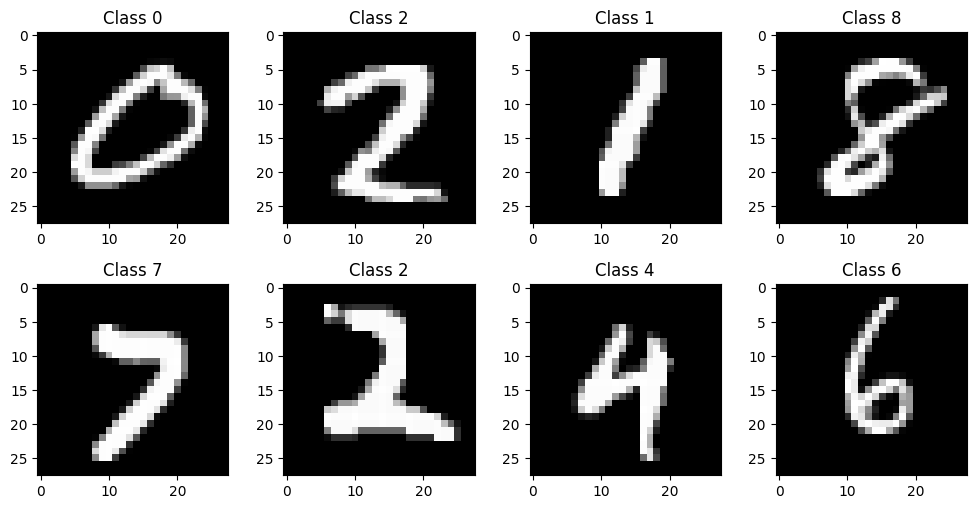

In [ ]:
# show image of training data
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10)) # set size of figure 10x10
rand_indexes = np.random.randint(0, x_train.shape[0], 8) # select 8 digits(0~9) randomly
print(rand_indexes)

for index,im_index in enumerate(rand_indexes):
    plt.subplot(4, 4, index+1)
    plt.imshow(x_train[im_index], cmap = 'gray', interpolation = 'none')
    plt.title('Class %d' % y_train[im_index])
plt.tight_layout()

<Axes: ylabel='count'>

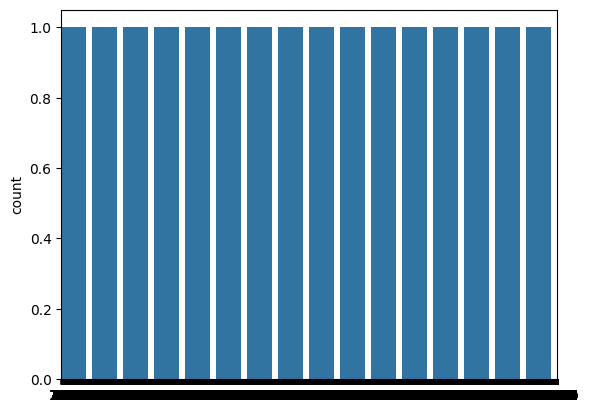

In [ ]:
sns.countplot(y_train)

# **2.2 Check for NaN Values**

In [ ]:
np.isnan(x_train).any()

np.False_

In [ ]:
np.isnan(x_test).any()

np.False_

There are no NaN values in our dataset. There is no need to preprocess the data to deal with Nan's.

# 2.3 Normalization and Reshaping

Since the values in our x_train dataset are 28x28 images, our input shape must be specified so that our model will know what is being inputed.

The first convolution layer expects a single 60000x28x28x1 tensor instead of 60000 28x28x1 tensors.

Models generally run better on normalized values. The best way to normalize the data depends on each individual dataset. For the MNIST dataset, we want each value to be between 0.0 and 1.0. As all values originally fall under the 0.0-255.0 range, divide by 255.0.

Run the following cell to define the input_shape and to normalize and reshape the data

In [ ]:
input_shape = (28, 28, 1)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

## 2.4 Label Encoding

The labels for the training and the testing dataset are currently categorical and is not continuous. To include categorical dataset in our model, our labels should be converted to one-hot encodings.

For example, 2 becomes [0,0,1,0,0,0,0,0,0,0] and 7 becomes [0,0,0,0,0,0,0,1,0,0].

Run the following cell to transform the labels into one-hot encodings

In [ ]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

# 2.5 Visualize Data

tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


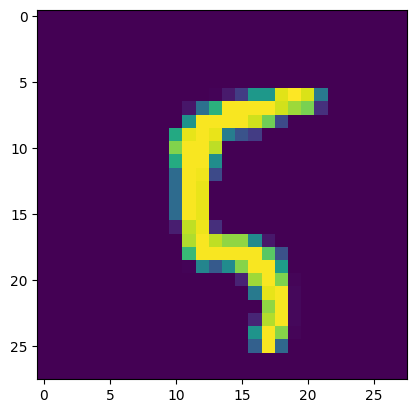

In [ ]:
plt.imshow(x_train[100][:,:,0])
print(y_train[100])

The image is an image of a handwritten 5. The one-hot encoding holds the value of 5

# **3. CNN**

In this module, we will build our CNN model

# 3.1 Define the Model

Run the following cell to define batch_size, num_classes, and epochs. Try changing the values and test how different values affect the accuracy of the CNN model.

In [ ]:
batch_size = 64
num_classes = 10
epochs = 5

Run the following cell to build the model. The model contains various layers stacked on top of each other. The output of one layer feeds into the input of the next layer.

Conv2D layers are convolutions. Each filter (32 in the first two convolution layers and 64 in the next two convolution layers) transforms a part of the image (5x5 for the first two Conv2D layers and 3x3 for the next two Conv2D layers). The transformation is applied on the whole image.

MaxPool2D is a downsampling filter. It reduces a 2x2 matrix of the image to a single pixel with the maximum value of the 2x2 matrix. The filter aims to conserve the main features of the image while reducing the size.

relu is the rectifier, and it is used to find nonlinearity in the data. It works by returning the input value if the input value >= 0. If the input is negative, it returns 0.

Flatten converts the tensors into a 1D vector.

The Dense layers are an artificial neural network. The last layer returns the probability that an image is in each class (one for each digit).

As this model aims to categorize the images, we will use a categorical_crossentropy loss function.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 3.2 Fit the Training Data

The next step is to fit our training data. If we achieve a certain level of accuracy, it may not be necessary to continue training the model, especially if time and resources are limited.

The following cell defines a CallBack so that if 99.5% accuracy is achieved, the model stops training.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

Testing the model on a validation dataset prevents overfitting of the data. We specified a 10% validation and 90% training split.

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - acc: 0.8899 - loss: 0.3412 - val_acc: 0.9873 - val_loss: 0.0451
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - acc: 0.9875 - loss: 0.0398 - val_acc: 0.9905 - val_loss: 0.0349
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.9918 - loss: 0.0260 - val_acc: 0.9893 - val_loss: 0.0432
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.9935 - loss: 0.0216 - val_acc: 0.9937 - val_loss: 0.0274
Epoch 5/5
840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9959 - loss: 0.0139
Reached 99.5% accuracy so cancelling training!
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - acc: 0.9959 - loss: 0.0139 - val_acc: 0.9902 - val_loss: 0.0367


# **4. Evaluate the Model**

Evaluate the model on the test set and analyze the accuracy

In [ ]:
#test model
preds = model.predict(x_test[0].reshape(-1,28,28,1))
print(int(np.argmax(preds)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
7


In [ ]:
#Evaluate Model
score = model.evaluate(x_test, y_test)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.9892 - loss: 0.0360
Test loss:  0.029264090582728386
Test accuracy:  0.9916999936103821


tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)


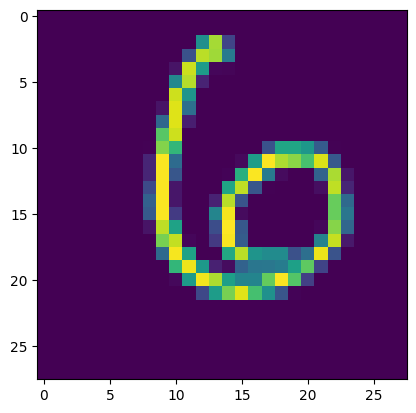

In [ ]:
plt.imshow(x_test[100][:,:,0])
print(y_test[100])

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test,verbose=2)
print("Test Accuracy: ", test_acc)
print("Test loss:", test_loss)

313/313 - 1s - 3ms/step - acc: 0.9917 - loss: 0.0293
Test Accuracy:  0.9916999936103821
Test loss: 0.029264090582728386


# 4.1 Loss and Accuracy Curves

Run the following cell to evaluate the loss and accuracy of our model.

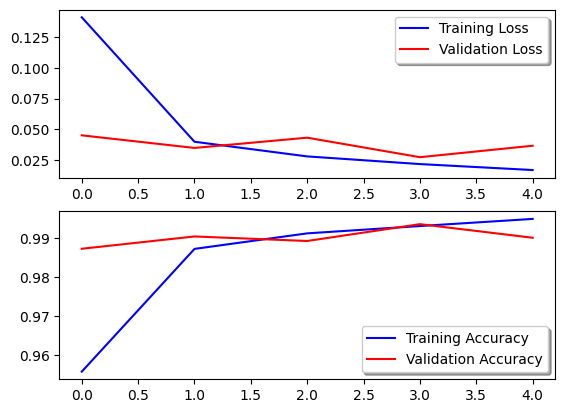

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss") # Removed axes = ax[0]
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

The accuracy increases over time and the loss decreases over time. However, the accuracy of our validation set seems to slightly decrease towards the end even thought our training accuracy increased. Running the model for more epochs might cause our model to be susceptible to overfitting.

Identify any overfitting and take measures for overfitting (e.g. add dropout layer) and plot training vs testing accuracy and loss.

Dropout is a regularization layer. In our model, 25% of the nodes in the layer are randomly ignores, allowing the network to learn different features. This prevents overfitting.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

Run the following cell to evaluate the loss and accuracy of our model.

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - acc: 0.8497 - loss: 0.4556 - val_acc: 0.9805 - val_loss: 0.0692
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.9747 - loss: 0.0835 - val_acc: 0.9905 - val_loss: 0.0311
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.9834 - loss: 0.0578 - val_acc: 0.9925 - val_loss: 0.0278
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.9859 - loss: 0.0462 - val_acc: 0.9915 - val_loss: 0.0283
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.9874 - loss: 0.0421 - val_acc: 0.9923 - val_loss: 0.0243


Plot training vs validation accuracy and loss

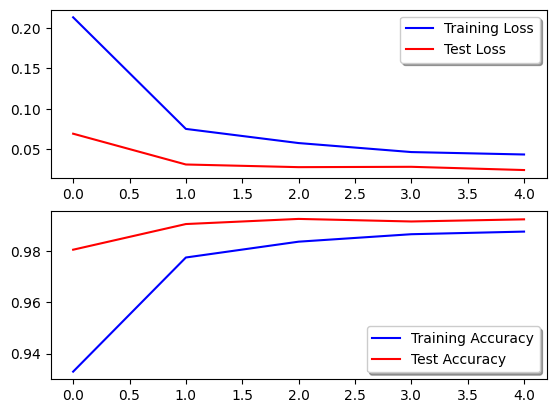

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Test Loss") # Removed axes = ax[0]
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Test Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# **4.2 Predict Results**

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9919 - loss: 0.0254


:Our model runs pretty well, with an accuracy of 99.0% on our testing data.

# **4.3 Confusion Matrix**

Run the following cell to compute our confusion matrix using TensorFlow.

In [ ]:
# Predict the values from the testing dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


<Axes: >

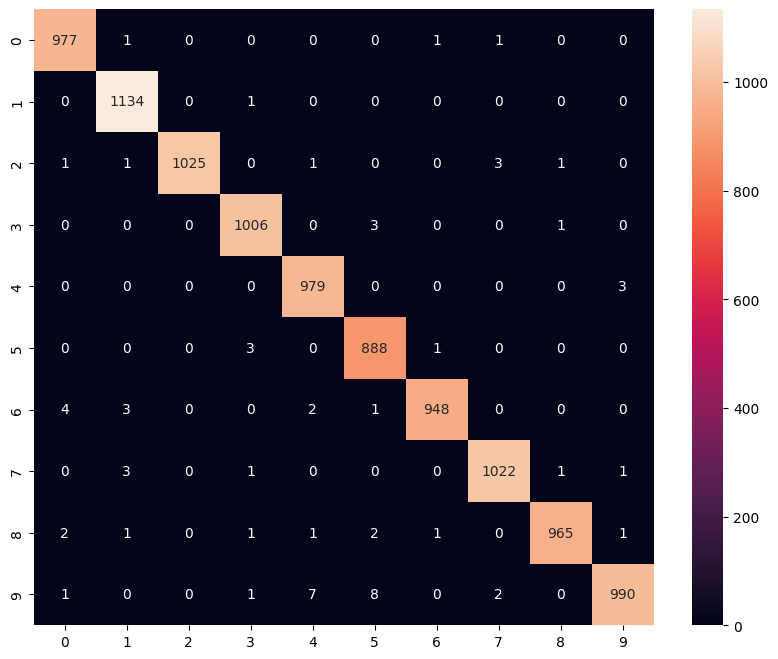

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

There seems to be a slightly higher confusion between (0,6) and (4,9). This is reasonable as 0's and 6's look similar with their loops and 4's and 9's can be mistaken when the 4's are more rounded and 9's are more angular.

In [ ]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f'  % acc)
print('Loss: %.3f' % loss)

Accuracy: 0.993
Loss: 0.021


Plot a few correct predicted samples and a few misclassified samples.

In [ ]:
# Show some wrong results, and the difference between the predicted label and the real labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

In [ ]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

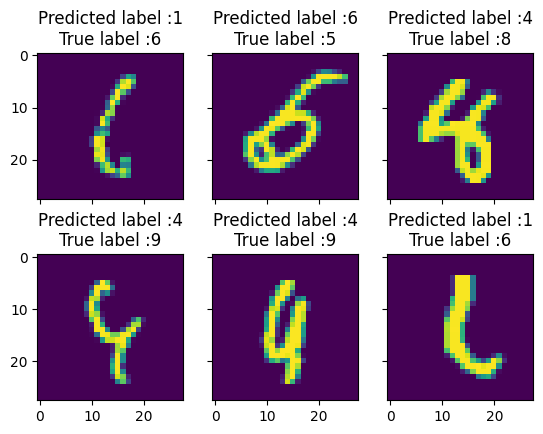

In [ ]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
#get the predictions for the test data
Y_pred = model.predict(x_test)
#get the indices to be plotted
y_true = np.argmax(y_test,axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
correct = np.nonzero(Y_pred_classes==y_true)[0]
misclassified = np.nonzero(Y_pred_classes!=y_true)[0]

In [ ]:
print("Correct predicted classes:",correct.shape[0])
print("Misclassified predicted classes:",misclassified.shape[0])

Correct predicted classes: 9934
Misclassified predicted classes: 66


**Displaying some Correct predicted samples**

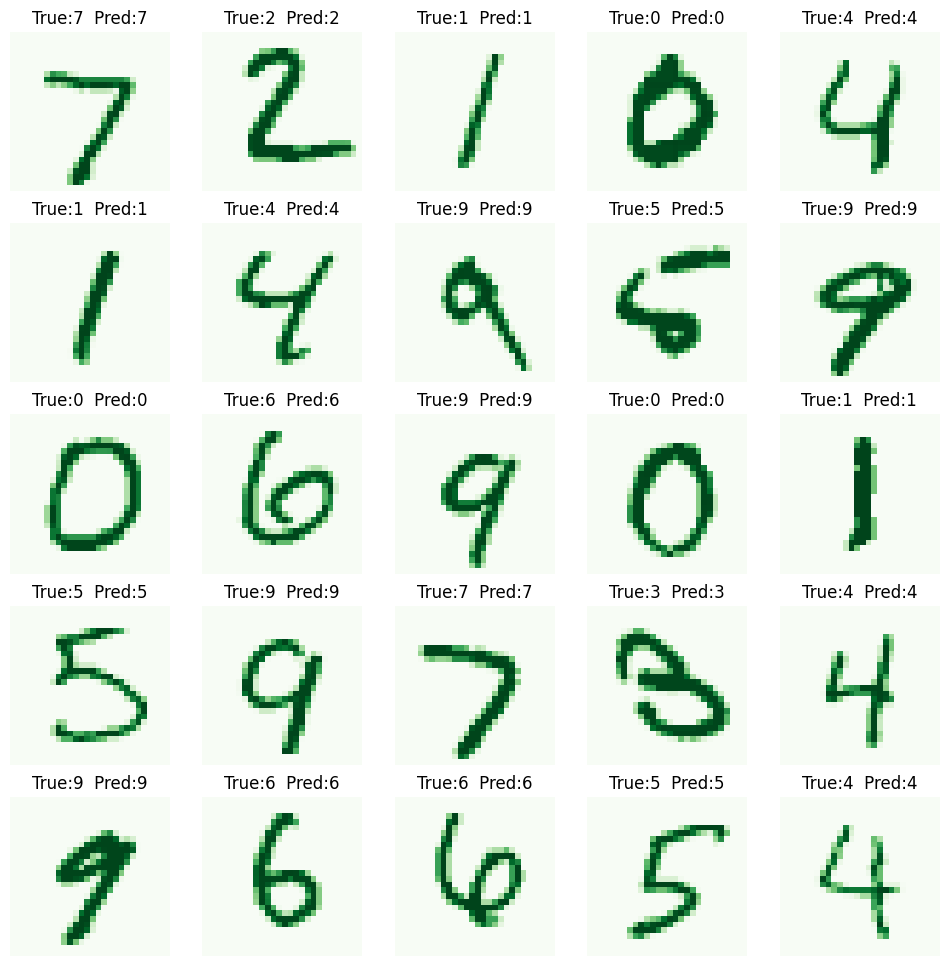

In [ ]:
def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(5,5, figsize=(12,12))

    for i, indx in enumerate(data_index[:25]):
        ax[i//5, i%5].imshow(x_test[indx].reshape(28,28), cmap=cmap)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("True:{}  Pred:{}".format(y_true[indx],Y_pred_classes[indx]))
    plt.show()

plot_images(correct, "Greens")

Displaying some Misclassified predicted samples

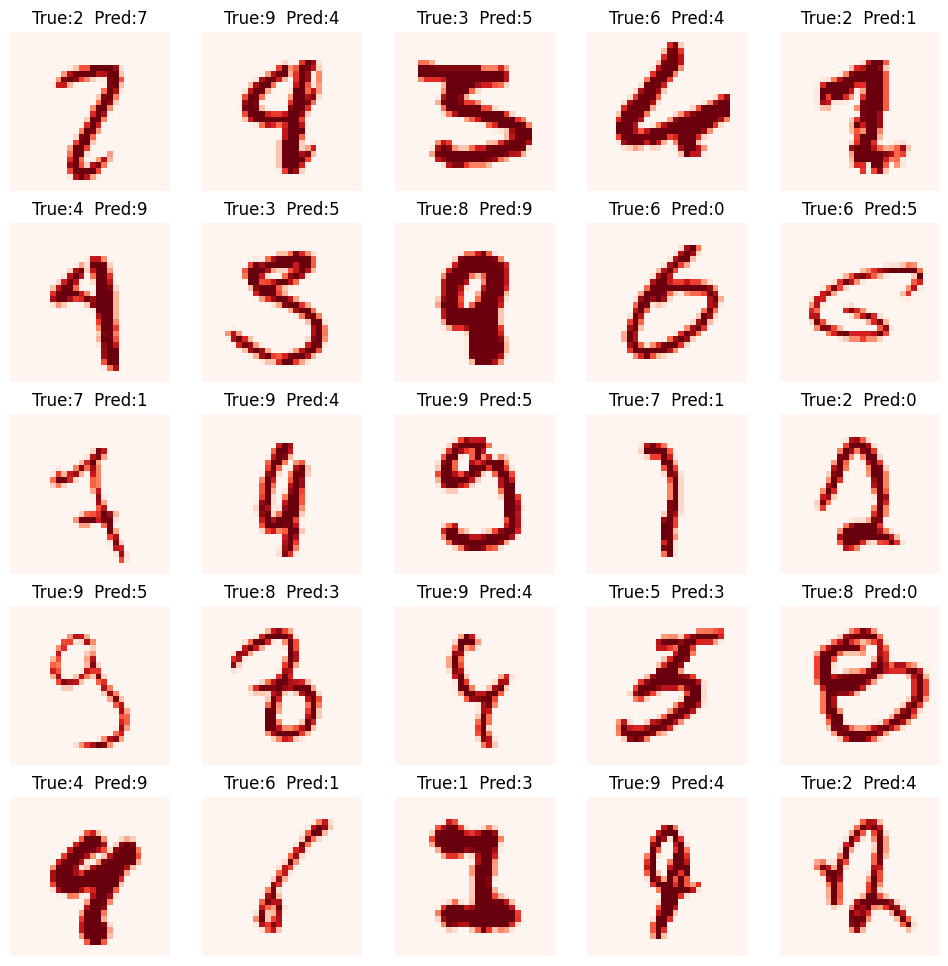

In [ ]:
plot_images(misclassified, "Reds")